In [1]:
import torch
from torchdyn.models import NeuralODE
import sys
sys.path.append("..")

# from src.train_cfm_latent import ConditionalFlowMatcher



In [2]:
import torch
import torch.nn as nn
from transformers import CLIPTextModel, CLIPTokenizer


class TextEncoder(nn.Module):
    def __init__(self, model_name: str, device: str):
        super().__init__()
        self.model_name = model_name
        self.model = CLIPTextModel.from_pretrained(model_name).to(device)
        self.tokenizer = CLIPTokenizer.from_pretrained(model_name)
        self.device = device
        # Get the text embedding dimension from the config
        self.text_embed_dim = self.model.config.hidden_size

    def forward(self, text: str) -> torch.Tensor:
        tokens = self.tokenizer(text, padding=True, truncation=True, return_tensors="pt").to(self.device)
        return self.model(**tokens).pooler_output

2025-01-09 04:03:05.972954: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-09 04:03:05.985018: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736395385.999750 3749567 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736395386.004122 3749567 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-09 04:03:06.021886: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

## Load pretrained model


In [3]:
from lib_4_1.model import create_unet_model
from lib_4_1.config import TrainingConfig
# generate images with text conditioning
# load the model
config = TrainingConfig(dataset="reese-green/afhq64_captions_64k", caption_column="caption_blip2-opt-2.7b", batch_size=8, resolution=32)
denoising_model = create_unet_model(config, config.device)
denoising_model.load_state_dict(torch.load("denoising_model_4_2.pth", map_location="cuda:0"))
denoising_model.eval()
text_encoder = TextEncoder("openai/clip-vit-large-patch14", "cuda:0")
text_encoder.eval()


model params: 14.68 M


/tmp/ipykernel_3749567/1191717415.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  denoising_model.load_state_dict(torch.load("denoising_model_4_2.pth", map_location="cud

TextEncoder(
  (model): CLIPTextModel(
    (text_model): CLIPTextTransformer(
      (embeddings): CLIPTextEmbeddings(
        (token_embedding): Embedding(49408, 768)
        (position_embedding): Embedding(77, 768)
      )
      (encoder): CLIPEncoder(
        (layers): ModuleList(
          (0-11): 12 x CLIPEncoderLayer(
            (self_attn): CLIPSdpaAttention(
              (k_proj): Linear(in_features=768, out_features=768, bias=True)
              (v_proj): Linear(in_features=768, out_features=768, bias=True)
              (q_proj): Linear(in_features=768, out_features=768, bias=True)
              (out_proj): Linear(in_features=768, out_features=768, bias=True)
            )
            (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (mlp): CLIPMLP(
              (activation_fn): QuickGELUActivation()
              (fc1): Linear(in_features=768, out_features=3072, bias=True)
              (fc2): Linear(in_features=3072, out_features=768, bias=T

## Text prompts

In [4]:
texts = ["null", "", "a black cat with a lot of fur", "a male lion"]
with torch.no_grad():
    text_embeddings = text_encoder(texts)
print(text_embeddings.shape)
# TODO: for empty text, set the text_embeddings to null_embedding
try:
    text_embeddings[0] = denoising_model.get_null_text_embed()
except Exception as e:
    print("Error: get_null_text_embed is not defined in the denoising_model")
    print(e)

torch.Size([4, 768])


In [5]:
import numpy as np
import matplotlib.pyplot as plt


class GeneratorModel(nn.Module):
    def __init__(self, denoising_model):
        super().__init__()
        self.denoising_model = denoising_model
        self.text_embeddings = None
        self.guidance_scale = 0
    
    def set_cond(self, text_embeddings, guidance_scale):
        self.text_embeddings = text_embeddings
        self.guidance_scale = guidance_scale

    def forward(self, t, x, *args, **kwargs):
        model = self.denoising_model
        text_embeddings = self.text_embeddings
        guidance_scale = self.guidance_scale
        if isinstance(t, int):
            t = torch.full((x.shape[0],), t, device=x.device)
        elif isinstance(t, torch.Tensor):
            # if t is a scalar
            if len(t.shape) == 0:
                t = torch.full((x.shape[0],), t, device=x.device)
            elif t.shape[0] == 1:
                t = t.repeat(x.shape[0])
        else:
            raise ValueError("t must be an integer or a tensor with the same number of elements as x")
        
        x_twice = torch.cat([x] * 2)
        t_twice = torch.cat([t] * 2)
        if text_embeddings is not None:
            uncond_embeddings = denoising_model.get_null_text_embed(batch_size=x.shape[0])
            embeddings_cat = torch.cat([uncond_embeddings, text_embeddings])
        else:
            embeddings_cat = None
            # print("No text embeddings for generation")
        
        with torch.no_grad():
            model_output = model(t=t_twice, x=x_twice, text_embeddings=embeddings_cat, p_uncond=0)
        
        # Split predictions and perform guidance
        v_t_uncond, v_t_cond = model_output.chunk(2)
        # print(f"v_t_uncond min: {v_t_uncond.min().item()}, max: {v_t_uncond.max().item()}, mean: {v_t_uncond.mean().item()}, std: {v_t_uncond.std().item()}")
        v_t = (1 - guidance_scale) * v_t_uncond + guidance_scale * v_t_cond
        # print(f"delta in v: {(v_t - v_t_uncond).mean().item()}")
        return v_t


def generate_samples_with_flow_matching(denoising_model, device, text_embeddings, guidance_scale, resolution: int = 32, in_channels: int = 3, parallel: bool = False, seed: int = 0, num_denoising_steps: int = 100):
    """Generate samples.

    Parameters
    ----------
    denoising_model:
        represents the neural network that we want to generate samples from
    parallel: bool
        represents the parallel training flag. Torchdyn only runs on 1 GPU, we need to send the models from several GPUs to 1 GPU.
    """
    model = denoising_model
    generator_model = GeneratorModel(denoising_model)
    generator_model.set_cond(text_embeddings, guidance_scale)
    num_samples = text_embeddings.shape[0]
    print(f"guidance scale: {guidance_scale}")
    
    if parallel:
        import copy
        model = copy.deepcopy(denoising_model)
        # Send the models from GPU to CPU for inference with NeuralODE from Torchdyn
        model = model.to(device)

    with torch.no_grad():
        torch.manual_seed(seed)
        
        # node = NeuralODE(f, solver="euler", sensitivity="adjoint")
        node = NeuralODE(generator_model, solver="euler", sensitivity="adjoint")
        with torch.no_grad():
            # Generate latents
            traj = node.trajectory(
                torch.randn(num_samples, in_channels, resolution, resolution, device=device),
                t_span=torch.linspace(0, 1, num_denoising_steps, device=device),
            )
            data = traj[-1, :].view([-1, in_channels, resolution, resolution]) # .clip(-1, 1)
    
    return data


def generate_and_show(**kwargs):
    torch.manual_seed(0)
    a = generate_samples_with_flow_matching(
        denoising_model=denoising_model,
        device="cuda:0",
        text_embeddings=text_embeddings,
        resolution=config.resolution,
        **kwargs,
    )
    
    # display images
    # convert from cuda to cpu
    a = a.cpu()
    # convert from torch to numpy
    a = a.numpy()
    # convert from (C, H, W) to (H, W, C)
    a = np.transpose(a, (0, 2, 3, 1))
    a = a - a.min()
    a = a / a.max()

    # make the figure a bit taller
    fig, axes = plt.subplots(2, 2, figsize=(6, 7))
    axes = axes.ravel()
    for i in range(4):
        axes[i].imshow(a[i])
        axes[i].set_title(texts[i])
    plt.tight_layout()
    # a caption for the whole figure
    plt.suptitle(f"Guidance scale: {kwargs.get('guidance_scale', 0)}, Seed: {kwargs.get('seed', 0)}")
    plt.show()

## Generate images with no text conditioning


guidance scale: 0


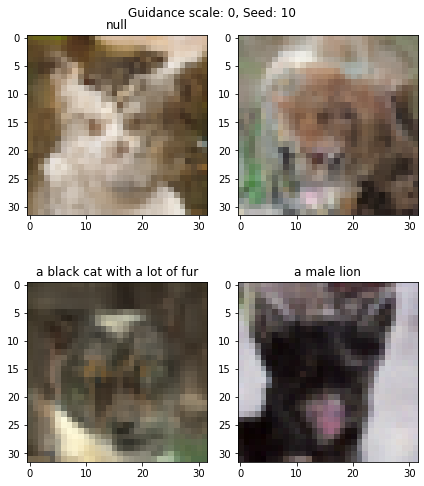

In [6]:
generate_and_show(
    guidance_scale=0, seed=10,
)

guidance scale: 5


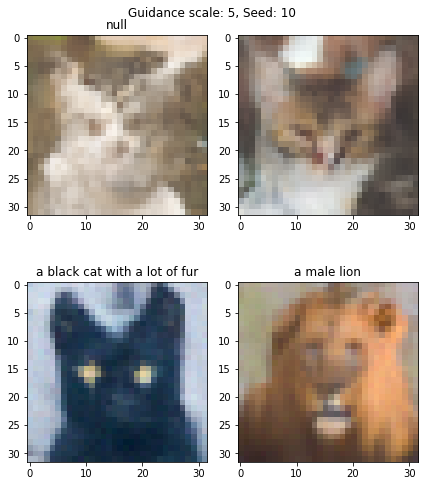

In [7]:
generate_and_show(
    guidance_scale=5, seed=10,
)

guidance scale: 7.5


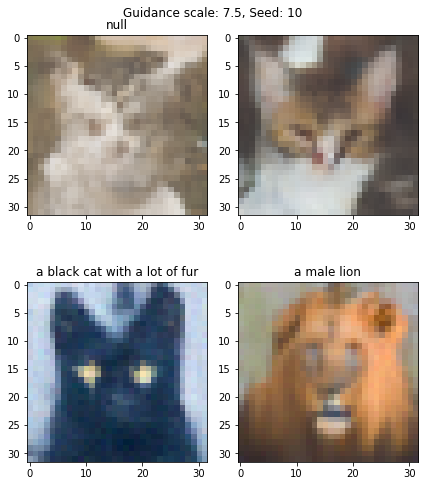

In [8]:
generate_and_show(
    guidance_scale=7.5, seed=10,
)

guidance scale: 10


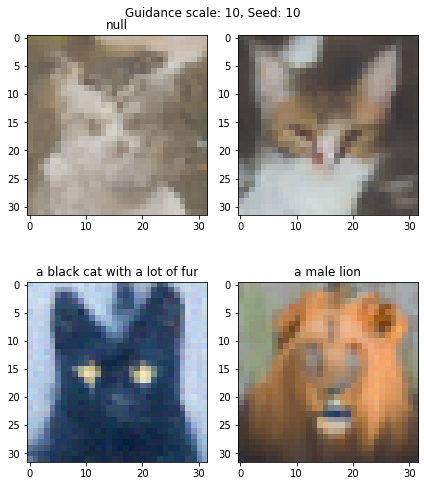

In [9]:
generate_and_show(
    guidance_scale=10, seed=10,
)

guidance scale: 5


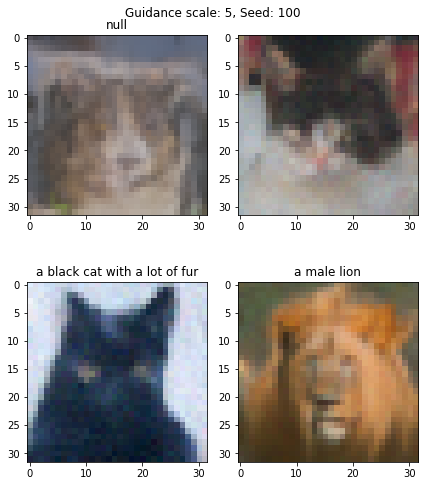

In [10]:
generate_and_show(
    guidance_scale=5, seed=100,
)

guidance scale: 5


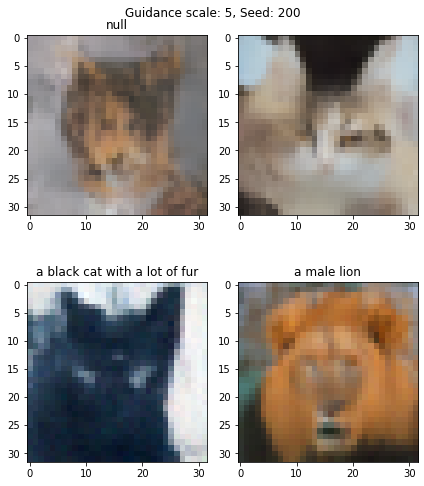

In [11]:
generate_and_show(
    guidance_scale=5, seed=200,
)

guidance scale: 5


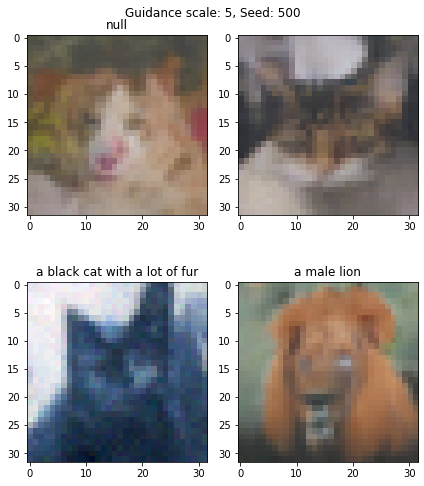

In [12]:
generate_and_show(
    guidance_scale=5, seed=500,
)